# Rational Expectations Agricultural Market Model

**Randall Romero Aguilar, PhD**

This demo is based on the original Matlab demo accompanying the  <a href="https://mitpress.mit.edu/books/applied-computational-economics-and-finance">Computational Economics and Finance</a> 2001 textbook by Mario Miranda and Paul Fackler.

Original (Matlab) CompEcon file: **demintro01.m**

Running this file requires the Python version of CompEcon. This can be installed with pip by running

    !pip install compecon --upgrade

<i>Last updated: 2021-Oct-01</i>
<hr>


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from compecon import demo, qnwlogn, discmoments
%matplotlib inline
plt.style.use('seaborn')

Generate yield distribution

In [2]:
sigma2 = 0.2 ** 2
y, w = qnwlogn(25, -0.5 * sigma2, sigma2)

Compute rational expectations equilibrium using function iteration, iterating on acreage planted

In [3]:
A = lambda aa, pp: 0.5 + 0.5 * np.dot(w, np.maximum(1.5 - 0.5 * aa * y, pp))

ptarg = 1
a = 1
for it in range(50):
    aold = a
    a = A(a, ptarg)
    print('{:3d} {:8.4f} {:8.1e}'.format(it, a, np.linalg.norm(a - aold)))
    if np.linalg.norm(a - aold) < 1.e-8:
        break

  0   1.0198  2.0e-02
  1   1.0171  2.7e-03
  2   1.0175  3.7e-04
  3   1.0174  5.0e-05
  4   1.0174  6.8e-06
  5   1.0174  9.3e-07
  6   1.0174  1.3e-07
  7   1.0174  1.7e-08
  8   1.0174  2.3e-09


Intermediate outputs

In [4]:
q = a * y                # quantity produced in each state
p = 1.5 - 0.5 * a * y    # market price in each state
f = np.maximum(p, ptarg) # farm price in each state
r = f * q                # farm revenue in each state
g = (f - p) * q          #government expenditures

xavg, xstd = discmoments(w, np.vstack((p, f, r, g)))
varnames = ['Market Price', 'Farm Price', 'Farm Revenue', 'Government Expenditures']

Print results

In [5]:
print('\n{:24s} {:8s} {:8s}'.format('Variable', 'Expect', 'Std Dev'))
for varname, av, sd in zip(varnames, xavg, xstd):
    print(f'{varname:24s} {av:8.4f} {sd:8.4f}')


Variable                 Expect   Std Dev 
Market Price               0.9913   0.1028
Farm Price                 1.0348   0.0506
Farm Revenue               1.0447   0.1773
Government Expenditures    0.0573   0.1038


Generate fixed-point mapping

In [6]:
aeq = a
a = np.linspace(0, 2, 100)
g = np.array([A(k, ptarg) for k in a])

### Graph rational expectations equilibrium

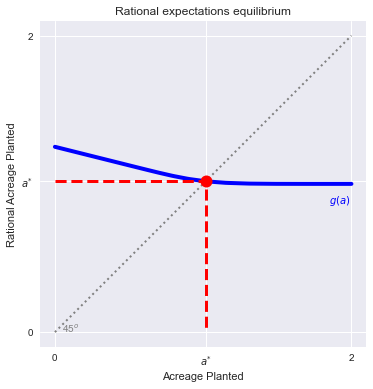

In [7]:
fig1 = plt.figure(figsize=[6, 6])
ax = fig1.add_subplot(111, title='Rational expectations equilibrium', aspect=1,
                       xlabel='Acreage Planted', xticks=[0, aeq, 2], xticklabels=['0', '$a^{*}$', '2'],
                       ylabel='Rational Acreage Planted', yticks=[0, aeq, 2],yticklabels=['0', '$a^{*}$', '2'])

ax.plot(a, g, 'b', linewidth=4)
ax.plot(a, a, ':', color='grey', linewidth=2)
ax.plot([0, aeq, aeq], [aeq, aeq, 0], 'r--', linewidth=3)
ax.plot([aeq], [aeq], 'ro', markersize=12)
ax.text(0.05, 0, '45${}^o$', color='grey')
ax.text(1.85, aeq - 0.15,'$g(a)$', color='blue')
fig1.show()

### Compute rational expectations equilibrium as a function of the target price

In [8]:
nplot = 50
ptarg = np.linspace(0, 2, nplot)
a = 1
Ep, Ef, Er, Eg, Sp, Sf, Sr, Sg = (np.empty(nplot) for k in range(8))

for ip in range(nplot):
    for it in range(50):
        aold = a
        a = A(a, ptarg[ip])
        if np.linalg.norm((a - aold) < 1.e-10):
            break

    q = a * y                       # quantity produced
    p = 1.5 - 0.5 * a * y           # market price
    f = np.maximum(p, ptarg[ip])    # farm price
    r = f * q                       # farm revenue
    g = (f - p) * q                 # government expenditures

    xavg, xstd = discmoments(w, np.vstack((p, f, r, g)))
    Ep[ip], Ef[ip], Er[ip], Eg[ip] = tuple(xavg)
    Sp[ip], Sf[ip], Sr[ip], Sg[ip] = tuple(xstd)


zeroline = lambda y: plt.axhline(y[0], linestyle=':', color='gray')

### Graph expected prices vs target price

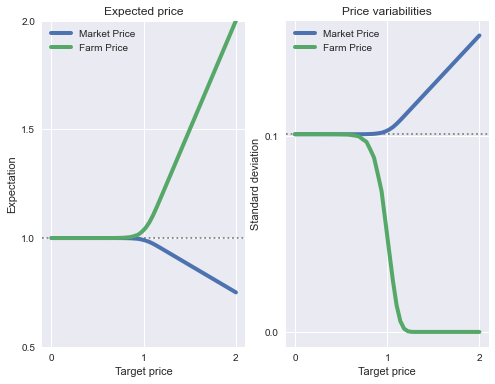

In [9]:
fig2 = plt.figure(figsize=[8, 6])
ax1 = fig2.add_subplot(121, title='Expected price',
                 xlabel='Target price', xticks=[0, 1, 2],
                 ylabel='Expectation', yticks=[0.5, 1, 1.5, 2], ylim=[0.5, 2.0])
zeroline(Ep)
ax1.plot(ptarg, Ep, linewidth=4, label='Market Price')
ax1.plot(ptarg, Ef, linewidth=4, label='Farm Price')
ax1.legend(loc='upper left')

# Graph expected prices vs target price
ax2 = fig2.add_subplot(122, title='Price variabilities',
                       xlabel='Target price', xticks=[0, 1, 2],
                       ylabel='Standard deviation', yticks=[0, 0.1, 0.2]) #plt.ylim(0.5, 2.0)
zeroline(Sf)
ax2.plot(ptarg, Sp, linewidth=4, label='Market Price')
ax2.plot(ptarg, Sf, linewidth=4, label='Farm Price')
ax2.legend(loc='upper left')
fig2.show()

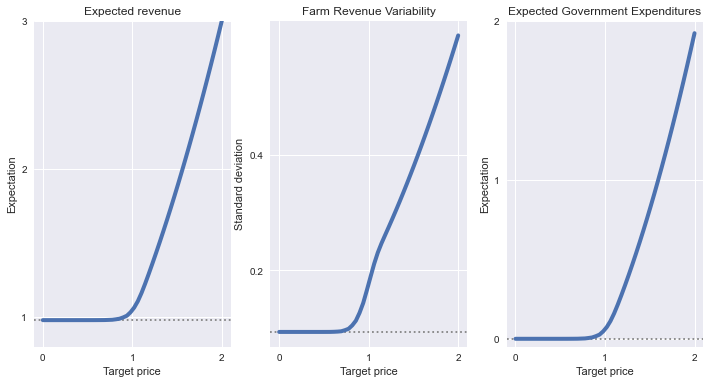

In [10]:
# Graph expected farm revenue vs target price
fig3 = plt.figure(figsize=[12, 6])
ax1 = fig3.add_subplot(131, title='Expected revenue',
                       xlabel='Target price', xticks=[0, 1, 2],
                       ylabel='Expectation', yticks=[1, 2, 3], ylim=[0.8, 3.0])
zeroline(Er)
ax1.plot(ptarg, Er, linewidth=4)


# Graph standard deviation of farm revenue vs target price
ax2 = fig3.add_subplot(132, title='Farm Revenue Variability',
                       xlabel='Target price', xticks=[0, 1, 2],
                       ylabel='Standard deviation', yticks=[0, 0.2, 0.4])
zeroline(Sr)
ax2.plot(ptarg, Sr, linewidth=4)


# Graph expected government expenditures vs target price
ax3 = fig3.add_subplot(133, title='Expected Government Expenditures',
                       xlabel='Target price', xticks=[0, 1, 2],
                       ylabel='Expectation', yticks=[0, 1, 2], ylim=[-0.05, 2.0])
zeroline(Eg)
ax3.plot(ptarg, Eg, linewidth=4)
plt.show()

In [11]:
#fig1.savefig('demintro02--01.png')
#fig2.savefig('demintro02--02.png')
#fig3.savefig('demintro02--03.png')